In [4]:
!python src/data/data_stats.py --data-root ../data/practicum_dataset

Поиск изображений и масок в ../data/practicum_dataset/img/train и ../data/practicum_dataset/labels/train

=== Статистика по split=train ===
Всего изображений: 200
Ширина  (px): min=256, max=256, mean=256.0
Высота  (px): min=256, max=256, mean=256.0
Топ 5 самых частых разрешений (width x height: count):
  256 x 256: 200

Классов (исключая ignore=255): 3
ID класса | пикселей      | доля, %
----------+---------------+--------
        0 |      11908826 |  90.86
        1 |        653268 |   4.98
        2 |        545106 |   4.16
Поиск изображений и масок в ../data/practicum_dataset/img/val и ../data/practicum_dataset/labels/val

=== Статистика по split=val ===
Всего изображений: 120
Ширина  (px): min=256, max=256, mean=256.0
Высота  (px): min=256, max=256, mean=256.0
Топ 5 самых частых разрешений (width x height: count):
  256 x 256: 120

Классов (исключая ignore=255): 3
ID класса | пикселей      | доля, %
----------+---------------+--------
        0 |       7019556 |  89.26
        1 | 

In [33]:
print(1/90.86, 1/4.98, 1/4.16)

0.01100594320933304 0.2008032128514056 0.24038461538461536


In [25]:
import numpy as np
w_raw = np.array([1./0.9086, 1./0.0498, 1./0.0416])
print(w_raw, np.sum(w_raw))
w = w_raw / np.sum(w_raw)
print(w, np.sum(w))

[ 1.10059432 20.08032129 24.03846154] 45.21937714453541
[0.024339   0.44406453 0.53159648] 1.0


In [5]:
!python src/data/analysis.py --data-root ../data/practicum_dataset


=== Split: train ===
Папка изображений: ../data/practicum_dataset/img/train
Папка масок     : ../data/practicum_dataset/labels/train
Файлов изображений: 200
Файлов масок      : 200
Пар (image+mask) : 200
Только изображений (без маски): 0
Только масок (без изображения): 0
Сохранены визуализации 5 пар в practicum_viz/train

=== Split: val ===
Папка изображений: ../data/practicum_dataset/img/val
Папка масок     : ../data/practicum_dataset/labels/val
Файлов изображений: 120
Файлов масок      : 120
Пар (image+mask) : 120
Только изображений (без маски): 0
Только масок (без изображения): 0
Сохранены визуализации 5 пар в practicum_viz/val

=== Split: test ===
Папка изображений: ../data/practicum_dataset/img/test
Папка масок     : ../data/practicum_dataset/labels/test
Файлов изображений: 120
Файлов масок      : 120
Пар (image+mask) : 120
Только изображений (без маски): 0
Только масок (без изображения): 0
Сохранены визуализации 5 пар в practicum_viz/test

Проверка завершена.


In [1]:
import os

os.environ["TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD"] = "1"

In [2]:
import os
from pathlib import Path

import numpy as np
import mmcv
import matplotlib.pyplot as plt

from mmengine import Config
from mmengine.runner import Runner

from mmseg.utils import register_all_modules
from mmseg.apis import init_model, inference_model, show_result_pyplot

print('Imports OK')


Imports OK


In [ ]:
cfg_path = '../configs/practicum/unet_fcn-256.py' 
cfg = Config.fromfile(cfg_path)

cfg.setdefault('work_dir', './work_dirs/unet_fcn-256')
cfg.setdefault('default_scope', 'mmseg')

cfg['randomness'] = dict(seed=0)

print(cfg.pretty_text[:1000]) 


In [ ]:
# Регистрируем модули mmseg
register_all_modules(init_default_scope=False)

runner = Runner.from_cfg(cfg)
runner.train()


Loads checkpoint by local backend from path: work_dirs/unet_fcn-256/epoch_300.pth


/home/kiriy/miniconda3/envs/ya_seg/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


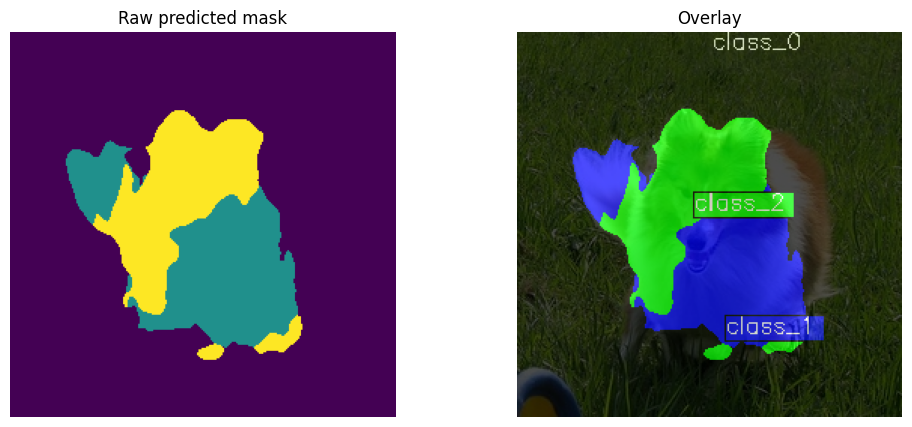

In [6]:
checkpoint_path = 'work_dirs/unet_fcn-256/epoch_300.pth'  

device = 'cuda:0'  # либо 'cpu'

register_all_modules()  # тут можно без init_default_scope=False

model = init_model(cfg_path, checkpoint_path, device=device)

# возьмём какое-нибудь изображение из валидации
img_path = '/home/kiriy/code/ya_seg/mmsegmentation/data/practicum_dataset/img/val/000000000307_5917.jpg' 
img = mmcv.imread(img_path)

result = inference_model(model, img)

# сырая маска классов
pred_mask = result.pred_sem_seg.data[0].cpu().numpy().astype(np.uint8)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Raw predicted mask')
plt.imshow(pred_mask)
plt.axis('off')

# оверлей
vis = show_result_pyplot(model, img, result, show=False, opacity=0.7)
plt.subplot(1, 2, 2)
plt.title('Overlay')
plt.imshow(mmcv.bgr2rgb(vis))
plt.axis('off')

plt.show()


Found 120 test images


/home/kiriy/miniconda3/envs/ya_seg/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


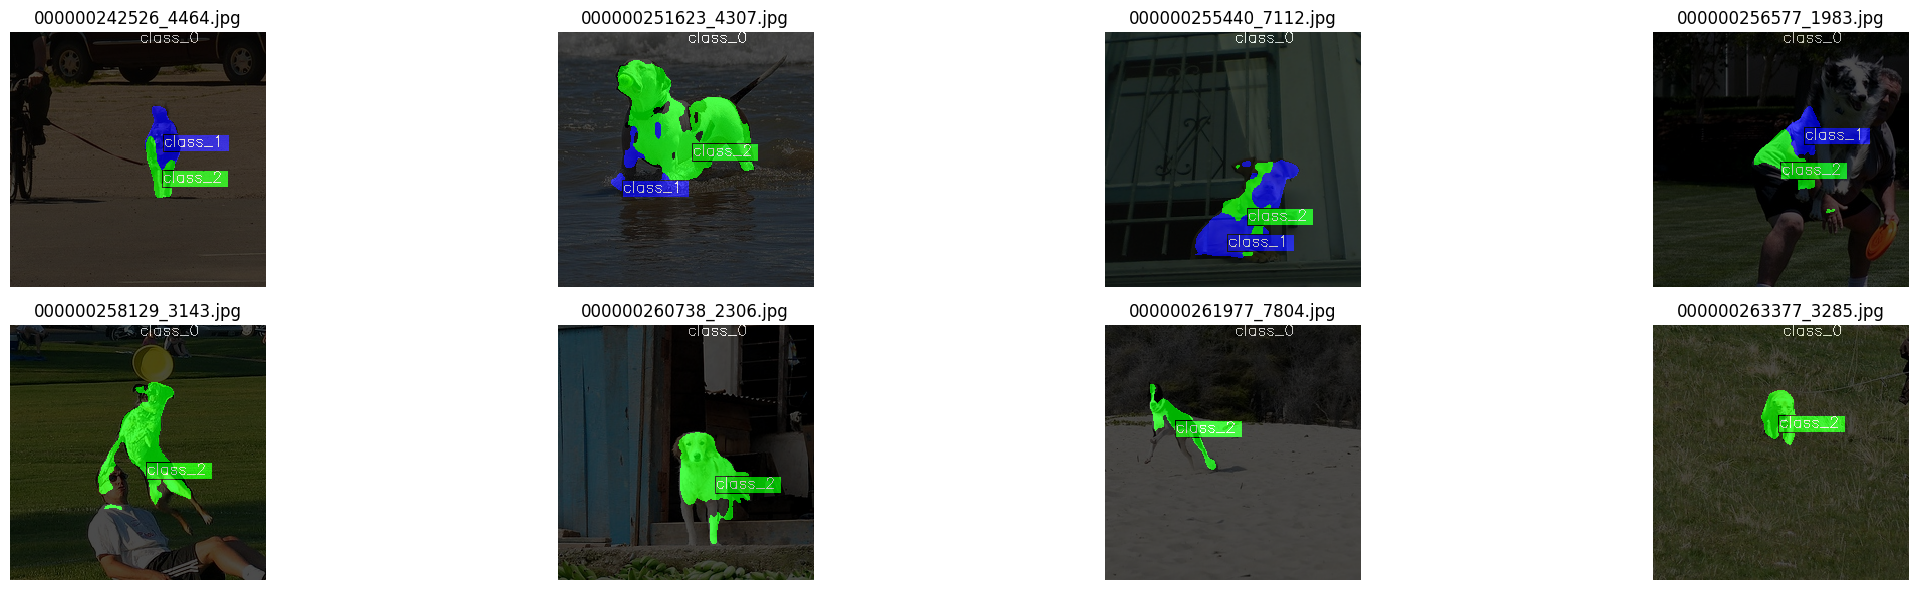

Visualizations saved to: outputs/unet_test_vis


In [ ]:
test_dir = Path('../data/practicum_dataset/img/test') 
out_dir = Path('outputs/unet_test_vis')
out_dir.mkdir(parents=True, exist_ok=True)

image_paths = sorted(test_dir.glob('*.jpg'))  
print(f'Found {len(image_paths)} test images')

n_show = min(8, len(image_paths))
fig, axes = plt.subplots(2, n_show // 2, figsize=(3 * n_show, 6))

for i, img_path in enumerate(image_paths[:n_show]):
    img = mmcv.imread(str(img_path))
    result = inference_model(model, img)

    vis = show_result_pyplot(
        model, img, result,
        show=False,
        opacity=0.7,
        out_file=str(out_dir / f'{img_path.stem}_vis.png')
    )

    ax = axes.flat[i]
    ax.imshow(mmcv.bgr2rgb(vis))
    ax.set_title(img_path.name)
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f'Visualizations saved to: {out_dir}')


In [28]:
!python src/analysis/plot_training_curves.py  work_dirs/unet_fcn-256/20251128_070045/vis_data/scalars.json \
  --out-dir work_dirs/unet_fcn-256/plots

Сохранён график train loss: work_dirs/unet_fcn-256/plots/train_loss.png
Сохранён график валидационных метрик: work_dirs/unet_fcn-256/plots/val_metrics.png
Сохранён график ошибки по mDice: work_dirs/unet_fcn-256/plots/val_mdice_error.png
Готово.


In [ ]:
!python src/analysis/infer_unet_fcn.py \
  ../configs/practicum/unet_fcn-256.py \
  work_dirs/unet_fcn-256/epoch_300.pth \
  ../data/practicum_dataset/img/val \
  --gt-root ../data/practicum_dataset/labels/val \
  --out-dir outputs/unet_val_eval \
  --ignore-index 255 \
  --top-k 10


In [ ]:
cfg_path = '../configs/practicum/unet_fcn-256_v2.py' 
cfg = Config.fromfile(cfg_path)

cfg.setdefault('work_dir', './work_dirs/unet_fcn-256_v2')
cfg.setdefault('default_scope', 'mmseg')

cfg['randomness'] = dict(seed=0)

print(cfg.pretty_text[:1000]) 

In [ ]:
register_all_modules(init_default_scope=False)

runner = Runner.from_cfg(cfg)
runner.train()

In [7]:
!python src/analysis/plot_training_curves.py  /home/kiriy/code/ya_seg/mmsegmentation/practicum_work/work_dirs/unet_fcn-256_v2/20251128_143011/vis_data/scalars.json \
  --out-dir work_dirs/unet_fcn-256_v2/plots

Сохранён график train loss: work_dirs/unet_fcn-256_v2/plots/train_loss.png
Сохранён график валидационных метрик: work_dirs/unet_fcn-256_v2/plots/val_metrics.png
Сохранён график ошибки по mDice: work_dirs/unet_fcn-256_v2/plots/val_mdice_error.png
Готово.


In [ ]:
!python src/analysis/infer_unet_fcn.py \
  ../configs/practicum/unet_fcn-256_v2.py \
  work_dirs/unet_fcn-256_v2/epoch_300.pth \
  ../data/practicum_dataset/img/val \
  --gt-root ../data/practicum_dataset/labels/val \
  --out-dir outputs/unet_val_eval_v2 \
  --ignore-index 255 \
  --top-k 10

/home/kiriy/code/ya_seg/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/home/kiriy/miniconda3/envs/ya_seg/lib/python3.10/site-packages/mmengine/runner/checkpoint.py:347: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  checkpoint = torch.load(filename, map_location=map_location)


Loads checkpoint by local backend from path: work_dirs/unet_fcn-256_v2/epoch_300.pth


/home/kiriy/miniconda3/envs/ya_seg/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


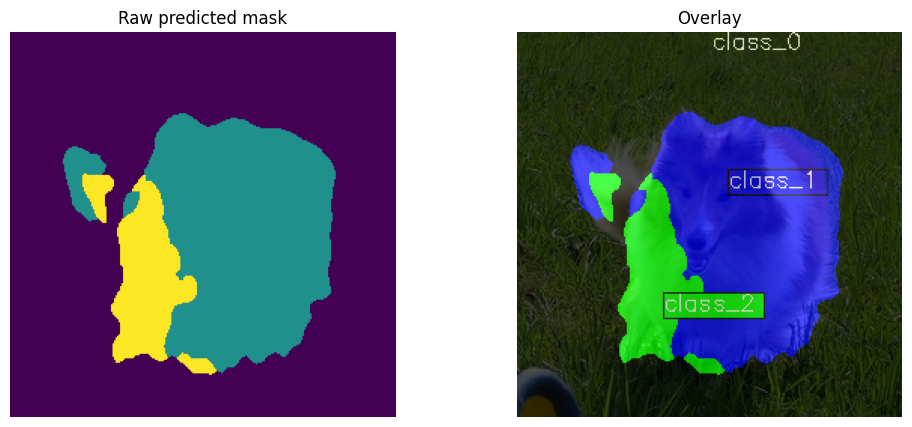

In [ ]:
checkpoint_path = 'work_dirs/unet_fcn-256_v2/epoch_300.pth'  

device = 'cuda:0' 

register_all_modules()

model = init_model(cfg_path, checkpoint_path, device=device)

img_path = '/home/kiriy/code/ya_seg/mmsegmentation/data/practicum_dataset/img/val/000000000307_5917.jpg' 
img = mmcv.imread(img_path)

result = inference_model(model, img)

pred_mask = result.pred_sem_seg.data[0].cpu().numpy().astype(np.uint8)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Raw predicted mask')
plt.imshow(pred_mask)
plt.axis('off')

# оверлей
vis = show_result_pyplot(model, img, result, show=False, opacity=0.7)
plt.subplot(1, 2, 2)
plt.title('Overlay')
plt.imshow(mmcv.bgr2rgb(vis))
plt.axis('off')

plt.show()


Found 120 test images


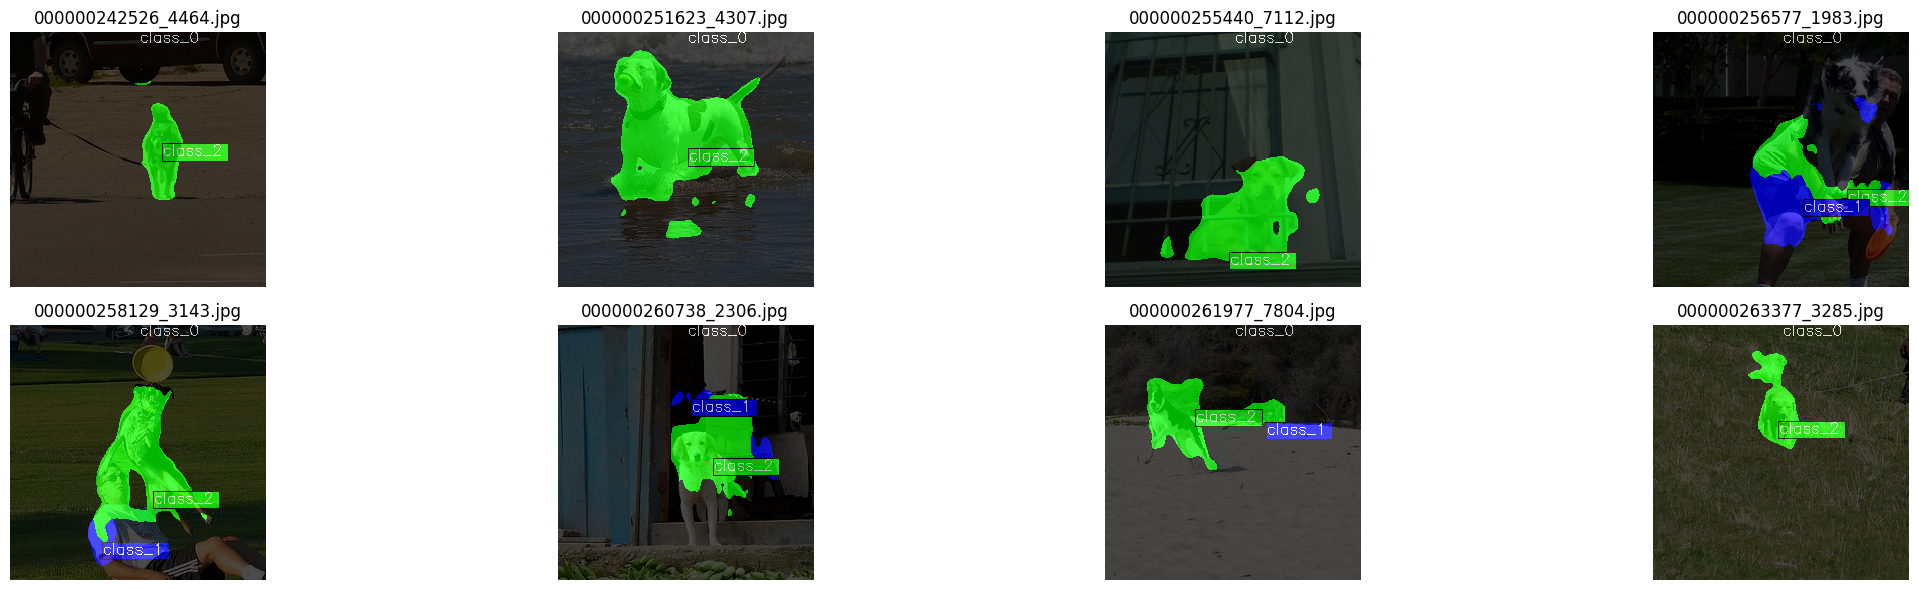

Visualizations saved to: outputs/unet_test_vis_v2


In [ ]:
test_dir = Path('../data/practicum_dataset/img/test') 
out_dir = Path('outputs/unet_test_vis_v2')
out_dir.mkdir(parents=True, exist_ok=True)

image_paths = sorted(test_dir.glob('*.jpg'))  
print(f'Found {len(image_paths)} test images')

n_show = min(8, len(image_paths))
fig, axes = plt.subplots(2, n_show // 2, figsize=(3 * n_show, 6))

for i, img_path in enumerate(image_paths[:n_show]):
    img = mmcv.imread(str(img_path))
    result = inference_model(model, img)

    vis = show_result_pyplot(
        model, img, result,
        show=False,
        opacity=0.7,
        out_file=str(out_dir / f'{img_path.stem}_vis.png')
    )

    ax = axes.flat[i]
    ax.imshow(mmcv.bgr2rgb(vis))
    ax.set_title(img_path.name)
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f'Visualizations saved to: {out_dir}')

In [3]:
cfg_path = '../configs/practicum/unet_fcn-256_v3.py' 
cfg = Config.fromfile(cfg_path)

cfg.setdefault('work_dir', './work_dirs/unet_fcn-256_v3')
cfg.setdefault('default_scope', 'mmseg')

cfg['randomness'] = dict(seed=0)

In [ ]:
register_all_modules(init_default_scope=False)

runner = Runner.from_cfg(cfg)
runner.train()

In [ ]:
checkpoint_path = 'work_dirs/unet_fcn-256_v3/epoch_300.pth'  

device = 'cuda:0' 

register_all_modules() 

model = init_model(cfg_path, checkpoint_path, device=device)

img_path = '/home/kiriy/code/ya_seg/mmsegmentation/data/practicum_dataset/img/val/000000000307_5917.jpg' 
img = mmcv.imread(img_path)

result = inference_model(model, img)

pred_mask = result.pred_sem_seg.data[0].cpu().numpy().astype(np.uint8)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Raw predicted mask')
plt.imshow(pred_mask)
plt.axis('off')

vis = show_result_pyplot(model, img, result, show=False, opacity=0.7)
plt.subplot(1, 2, 2)
plt.title('Overlay')
plt.imshow(mmcv.bgr2rgb(vis))
plt.axis('off')

plt.show()


Found 120 test images


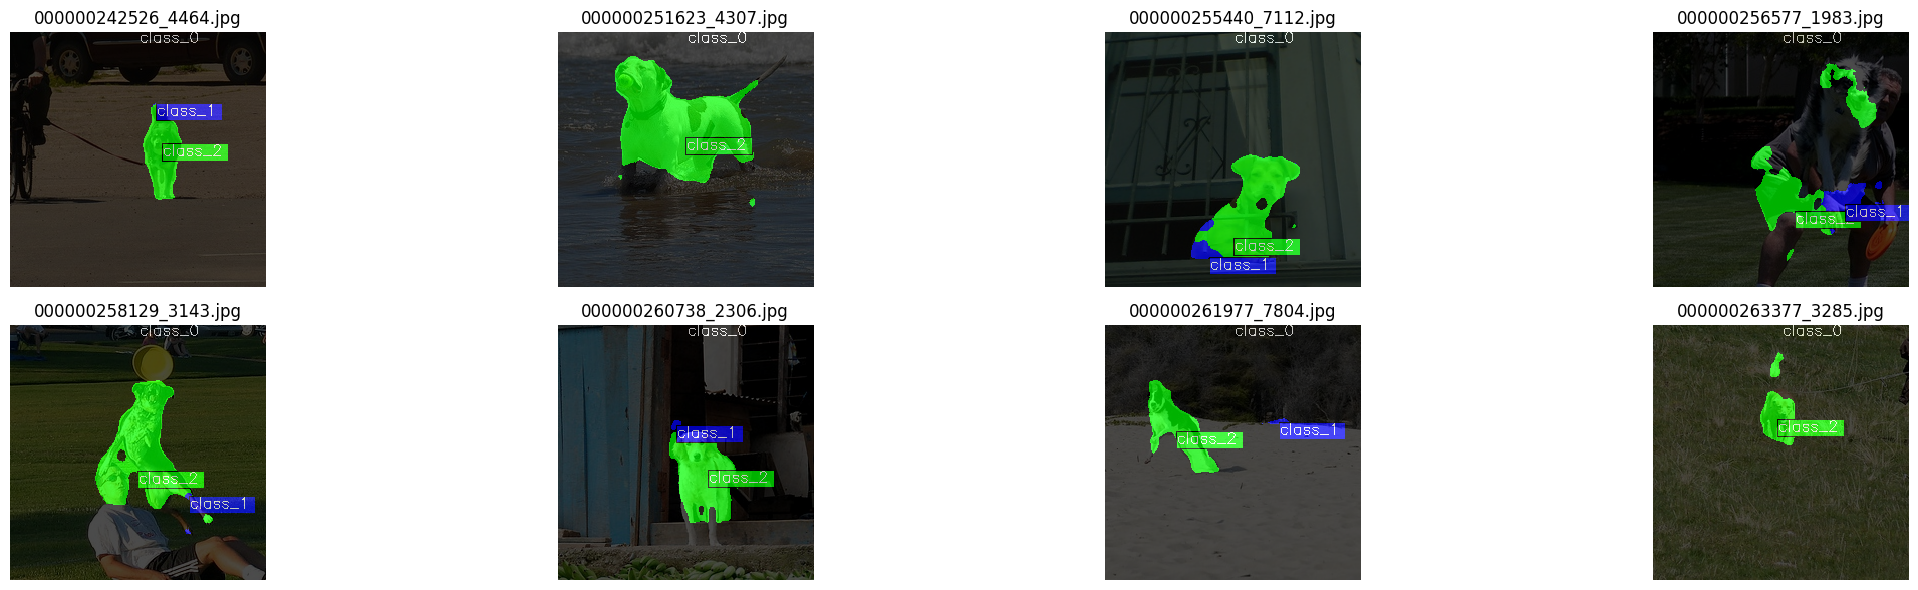

Visualizations saved to: outputs/unet_test_vis_v3


In [ ]:
test_dir = Path('../data/practicum_dataset/img/test') 
out_dir = Path('outputs/unet_test_vis_v3')
out_dir.mkdir(parents=True, exist_ok=True)

image_paths = sorted(test_dir.glob('*.jpg'))  
print(f'Found {len(image_paths)} test images')

n_show = min(8, len(image_paths))
fig, axes = plt.subplots(2, n_show // 2, figsize=(3 * n_show, 6))

for i, img_path in enumerate(image_paths[:n_show]):
    img = mmcv.imread(str(img_path))
    result = inference_model(model, img)

    vis = show_result_pyplot(
        model, img, result,
        show=False,
        opacity=0.7,
        out_file=str(out_dir / f'{img_path.stem}_vis.png')
    )

    ax = axes.flat[i]
    ax.imshow(mmcv.bgr2rgb(vis))
    ax.set_title(img_path.name)
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f'Visualizations saved to: {out_dir}')

In [ ]:
!python src/analysis/infer_unet_fcn.py \
  ../configs/practicum/unet_fcn-256_v3.py \
  work_dirs/unet_fcn-256_v3/epoch_300.pth \
  ../data/practicum_dataset/img/val \
  --gt-root ../data/practicum_dataset/labels/val \
  --out-dir outputs/unet_val_eval_v3 \
  --ignore-index 255 \
  --top-k 10

In [19]:
import pandas as pd
import numpy as np

mdice_arr = np.array(pd.read_csv('outputs/unet_val_eval/mdice_per_sample.csv')['mdice'])
print('v1')
print('mean:\t{}\nmedian:\t{}'.format(mdice_arr.mean(), np.median(mdice_arr)))

mdice_arr = np.array(pd.read_csv('outputs/unet_val_eval_v2/mdice_per_sample.csv')['mdice'])
print('v2')
print('mean:\t{}\nmedian:\t{}'.format(mdice_arr.mean(), np.median(mdice_arr)))

mdice_arr = np.array(pd.read_csv('outputs/unet_val_eval_v3/mdice_per_sample.csv')['mdice'])
print('v3')
print('mean:\t{}\nmedian:\t{}'.format(mdice_arr.mean(), np.median(mdice_arr)))

v1
mean:	0.565803896170637
median:	0.5203682753835254
v2
mean:	0.5219505767659754
median:	0.5103131261324554
v3
mean:	0.6130907414506731
median:	0.5747422440087055


In [3]:
cfg_path = '../configs/practicum/unet_fcn-256_v4.py' 
cfg = Config.fromfile(cfg_path)

cfg.setdefault('work_dir', './work_dirs/unet_fcn-256_v4')
cfg.setdefault('default_scope', 'mmseg')

cfg['randomness'] = dict(seed=0)

In [ ]:
register_all_modules(init_default_scope=False)

runner = Runner.from_cfg(cfg)
runner.train()

/home/kiriy/code/ya_seg/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning:

Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.

/home/kiriy/miniconda3/envs/ya_seg/lib/python3.10/site-packages/clearml/binding/frameworks/pytorch_bind.py:270: UserWarning:

Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.

/home/kiriy/miniconda3/envs/ya_seg/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:196: UserWarning:

Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.



Loads checkpoint by local backend from path: work_dirs/unet_fcn-256_v4/epoch_300.pth


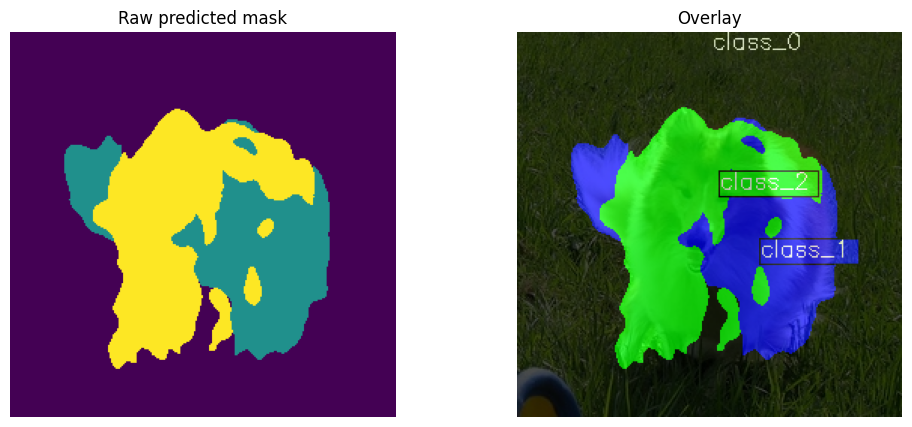

In [5]:
checkpoint_path = 'work_dirs/unet_fcn-256_v4/epoch_300.pth'  

device = 'cuda:0' 

register_all_modules() 

model = init_model(cfg_path, checkpoint_path, device=device)

img_path = '/home/kiriy/code/ya_seg/mmsegmentation/data/practicum_dataset/img/val/000000000307_5917.jpg' 
img = mmcv.imread(img_path)

result = inference_model(model, img)

pred_mask = result.pred_sem_seg.data[0].cpu().numpy().astype(np.uint8)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Raw predicted mask')
plt.imshow(pred_mask)
plt.axis('off')

vis = show_result_pyplot(model, img, result, show=False, opacity=0.7)
plt.subplot(1, 2, 2)
plt.title('Overlay')
plt.imshow(mmcv.bgr2rgb(vis))
plt.axis('off')

plt.show()


Found 120 test images


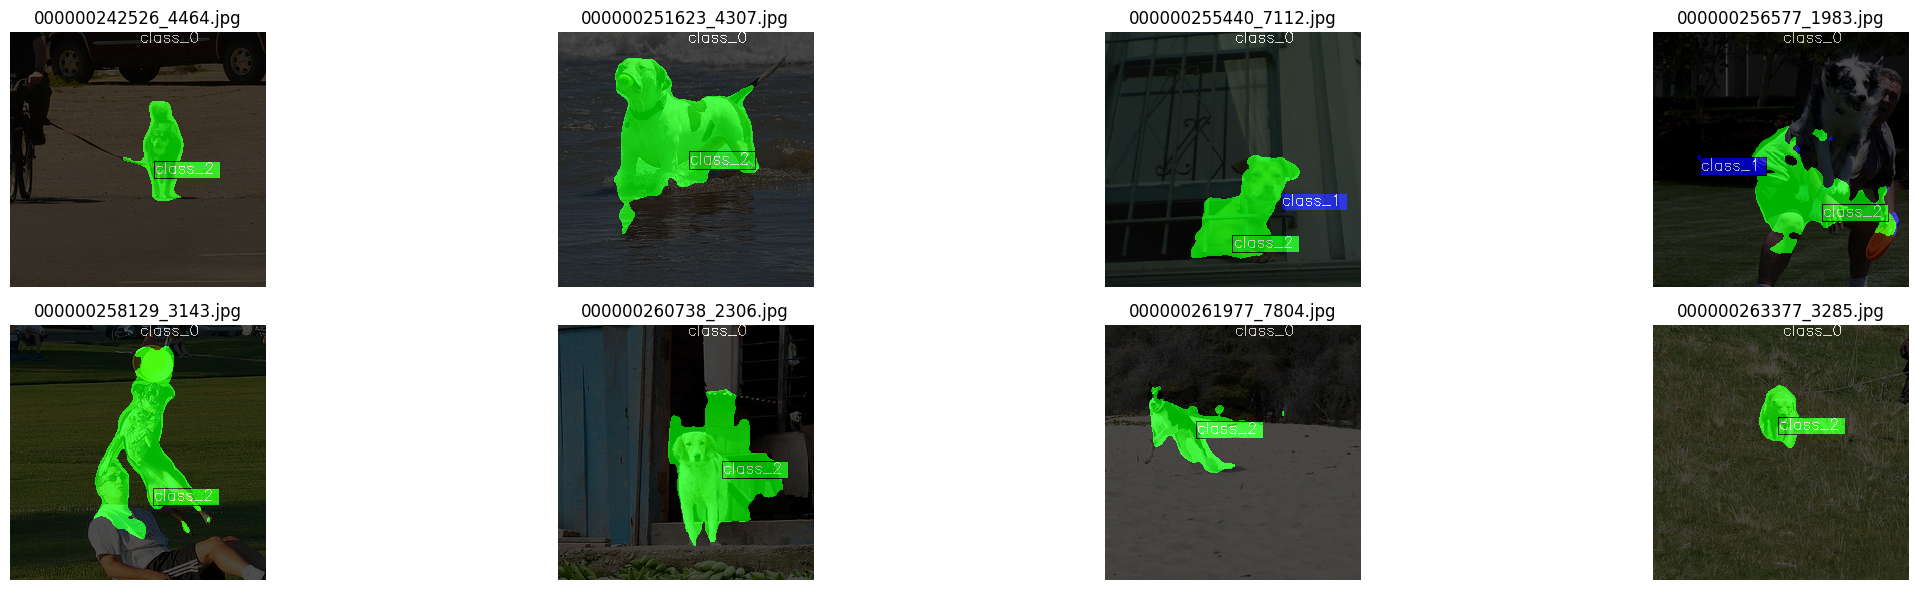

Visualizations saved to: outputs/unet_test_vis_v4


In [6]:
test_dir = Path('../data/practicum_dataset/img/test') 
out_dir = Path('outputs/unet_test_vis_v4')
out_dir.mkdir(parents=True, exist_ok=True)

image_paths = sorted(test_dir.glob('*.jpg'))  
print(f'Found {len(image_paths)} test images')

n_show = min(8, len(image_paths))
fig, axes = plt.subplots(2, n_show // 2, figsize=(3 * n_show, 6))

for i, img_path in enumerate(image_paths[:n_show]):
    img = mmcv.imread(str(img_path))
    result = inference_model(model, img)

    vis = show_result_pyplot(
        model, img, result,
        show=False,
        opacity=0.7,
        out_file=str(out_dir / f'{img_path.stem}_vis.png')
    )

    ax = axes.flat[i]
    ax.imshow(mmcv.bgr2rgb(vis))
    ax.set_title(img_path.name)
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f'Visualizations saved to: {out_dir}')

In [ ]:
!python src/analysis/infer_unet_fcn.py \
  ../configs/practicum/unet_fcn-256_v4.py \
  work_dirs/unet_fcn-256_v4/epoch_300.pth \
  ../data/practicum_dataset/img/val \
  --gt-root ../data/practicum_dataset/labels/val \
  --out-dir outputs/unet_val_eval_v4 \
  --ignore-index 255 \
  --top-k 10

In [5]:
cfg_path = '../configs/practicum/unet_fcn-256_v5.py' 
cfg = Config.fromfile(cfg_path)

cfg.setdefault('work_dir', './work_dirs/unet_fcn-256_v5')
cfg.setdefault('default_scope', 'mmseg')

cfg['randomness'] = dict(seed=0)

In [ ]:
register_all_modules(init_default_scope=False)

runner = Runner.from_cfg(cfg)
runner.train()

/home/kiriy/code/ya_seg/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning:

Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.

/home/kiriy/miniconda3/envs/ya_seg/lib/python3.10/site-packages/clearml/binding/frameworks/pytorch_bind.py:270: UserWarning:

Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.



Loads checkpoint by local backend from path: work_dirs/unet_fcn-256_v5/epoch_300.pth


/home/kiriy/miniconda3/envs/ya_seg/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:196: UserWarning:

Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.



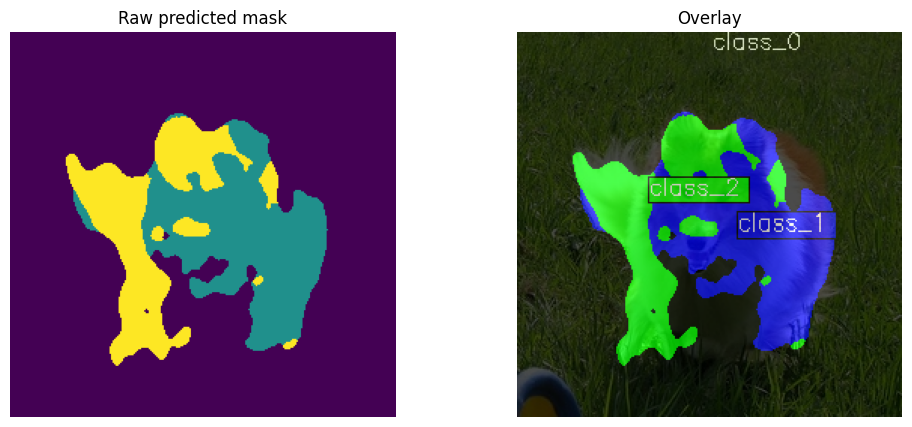

In [7]:
checkpoint_path = 'work_dirs/unet_fcn-256_v5/epoch_300.pth'  

device = 'cuda:0' 

register_all_modules() 

model = init_model(cfg_path, checkpoint_path, device=device)

img_path = '/home/kiriy/code/ya_seg/mmsegmentation/data/practicum_dataset_drop/img/val/000000000307_5917.jpg' 
img = mmcv.imread(img_path)

result = inference_model(model, img)

pred_mask = result.pred_sem_seg.data[0].cpu().numpy().astype(np.uint8)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Raw predicted mask')
plt.imshow(pred_mask)
plt.axis('off')

vis = show_result_pyplot(model, img, result, show=False, opacity=0.7)
plt.subplot(1, 2, 2)
plt.title('Overlay')
plt.imshow(mmcv.bgr2rgb(vis))
plt.axis('off')

plt.show()


Found 120 test images


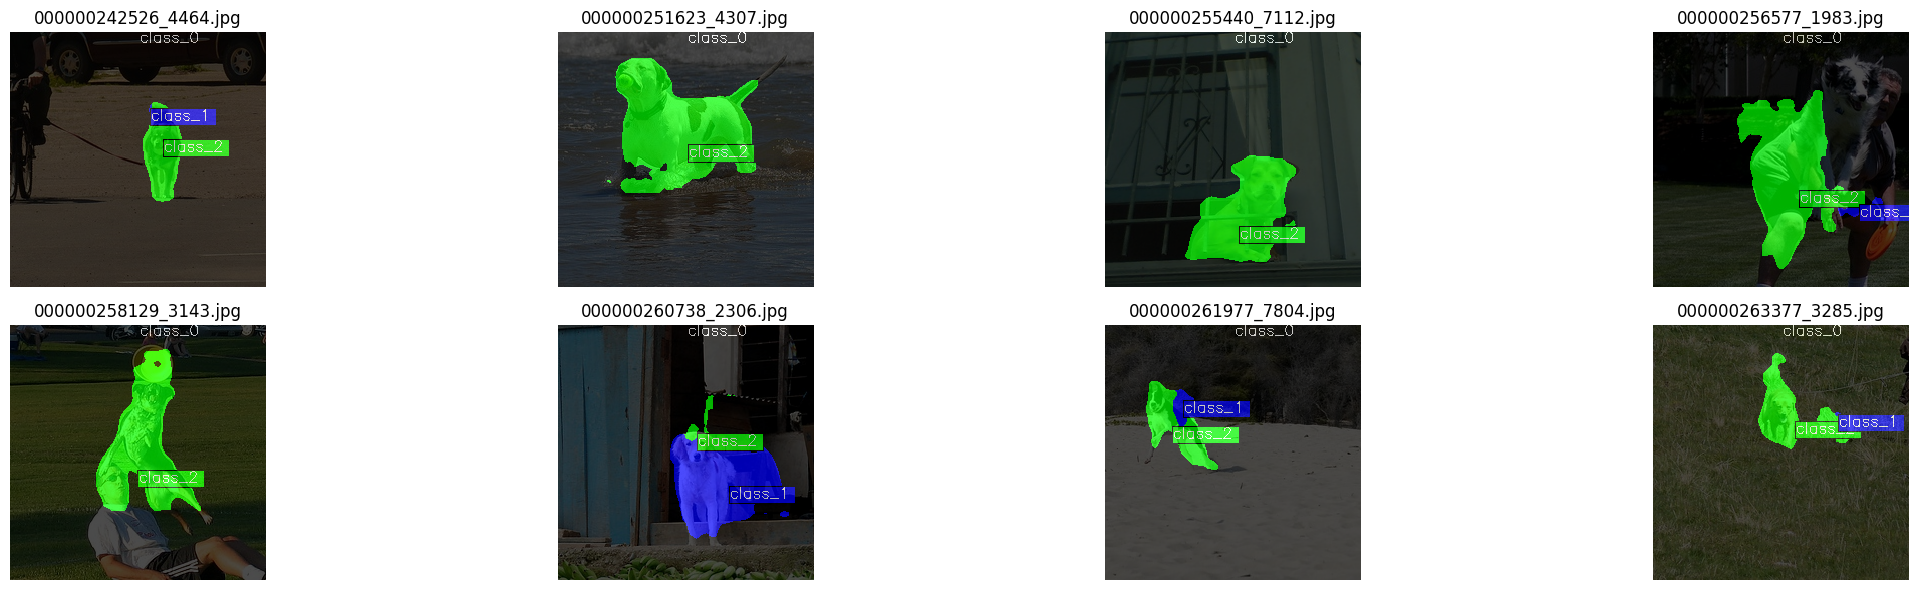

Visualizations saved to: outputs/unet_test_vis_v5


In [8]:
test_dir = Path('../data/practicum_dataset_drop/img/test') 
out_dir = Path('outputs/unet_test_vis_v5')
out_dir.mkdir(parents=True, exist_ok=True)

image_paths = sorted(test_dir.glob('*.jpg'))  
print(f'Found {len(image_paths)} test images')

n_show = min(8, len(image_paths))
fig, axes = plt.subplots(2, n_show // 2, figsize=(3 * n_show, 6))

for i, img_path in enumerate(image_paths[:n_show]):
    img = mmcv.imread(str(img_path))
    result = inference_model(model, img)

    vis = show_result_pyplot(
        model, img, result,
        show=False,
        opacity=0.7,
        out_file=str(out_dir / f'{img_path.stem}_vis.png')
    )

    ax = axes.flat[i]
    ax.imshow(mmcv.bgr2rgb(vis))
    ax.set_title(img_path.name)
    ax.axis('off')

plt.tight_layout()
plt.show()

print(f'Visualizations saved to: {out_dir}')

In [ ]:
!python src/analysis/infer_unet_fcn.py \
  ../configs/practicum/unet_fcn-256_v5.py \
  work_dirs/unet_fcn-256_v5/epoch_300.pth \
  ../data/practicum_dataset_drop/img/val \
  --gt-root ../data/practicum_dataset_drop/labels/val \
  --out-dir outputs/unet_val_eval_v5 \
  --ignore-index 255 \
  --top-k 10

In [12]:
import pandas as pd
import numpy as np

mdice_arr = np.array(pd.read_csv('outputs/unet_val_eval/mdice_per_sample.csv')['mdice'])
print('v1')
print('mean:\t{}\nmedian:\t{}'.format(mdice_arr.mean(), np.median(mdice_arr)))

mdice_arr = np.array(pd.read_csv('outputs/unet_val_eval_v2/mdice_per_sample.csv')['mdice'])
print('v2')
print('mean:\t{}\nmedian:\t{}'.format(mdice_arr.mean(), np.median(mdice_arr)))

mdice_arr = np.array(pd.read_csv('outputs/unet_val_eval_v3/mdice_per_sample.csv')['mdice'])
print('v3')
print('mean:\t{}\nmedian:\t{}'.format(mdice_arr.mean(), np.median(mdice_arr)))

mdice_arr = np.array(pd.read_csv('outputs/unet_val_eval_v4/mdice_per_sample.csv')['mdice'])
print('v4')
print('mean:\t{}\nmedian:\t{}'.format(mdice_arr.mean(), np.median(mdice_arr)))

mdice_arr = np.array(pd.read_csv('outputs/unet_val_eval_v5/mdice_per_sample.csv')['mdice'])
print('v5')
print('mean:\t{}\nmedian:\t{}'.format(mdice_arr.mean(), np.median(mdice_arr)))

v1
mean:	0.565803896170637
median:	0.5203682753835254
v2
mean:	0.5219505767659754
median:	0.5103131261324554
v3
mean:	0.6127323412046178
median:	0.5731888444039235
v4
mean:	0.5695496643331882
median:	0.5546085336438648
v5
mean:	0.5623687943231563
median:	0.5552623228051513


In [ ]:
!python src/analysis/plot_training_curves.py  work_dirs/unet_fcn-256_v3/20251129_053027/vis_data/scalars.json \
  --out-dir work_dirs/unet_fcn-256_v3/plots

Сохранён график train loss: work_dirs/unet_fcn-256_v3/plots/train_loss.png
Сохранён график валидационных метрик: work_dirs/unet_fcn-256_v3/plots/val_metrics.png
Сохранён график ошибки по mDice: work_dirs/unet_fcn-256_v3/plots/val_mdice_error.png
Готово.


In [15]:
!python src/analysis/plot_training_curves.py  work_dirs/unet_fcn-256_v4/20251129_015427/vis_data/scalars.json \
  --out-dir work_dirs/unet_fcn-256_v4/plots

Сохранён график train loss: work_dirs/unet_fcn-256_v4/plots/train_loss.png
Сохранён график валидационных метрик: work_dirs/unet_fcn-256_v4/plots/val_metrics.png
Сохранён график ошибки по mDice: work_dirs/unet_fcn-256_v4/plots/val_mdice_error.png
Готово.


In [2]:
!python src/analysis/plot_training_curves.py  work_dirs/unet_fcn-256_v5/20251129_223721/vis_data/scalars.json \
  --out-dir work_dirs/unet_fcn-256_v5/plots

Сохранён график train loss: work_dirs/unet_fcn-256_v5/plots/train_loss.png
Сохранён график валидационных метрик: work_dirs/unet_fcn-256_v5/plots/val_metrics.png
Сохранён график ошибки по mDice: work_dirs/unet_fcn-256_v5/plots/val_mdice_error.png
Готово.
